# Depth Data Visualization with Bounding Box

This notebook loads saved depth data from the `saved_depth_images` folder and visualizes both the depth data and its axis-aligned bounding box.

## Features:
- Load saved depth images and raw depth data
- Convert depth data to 3D point cloud
- Visualize point cloud with height-based coloring
- Display axis-aligned bounding box
- Interactive 3D visualization with Open3D
- 2D projections and statistical analysis
- Multiple depth image sets support


In [39]:
# Import required libraries
import open3d as o3d
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# Add the current directory to the path to import load_depth_images
sys.path.append(str(Path.cwd()))

# Set up paths
notebook_dir = Path.cwd()
saved_depth_dir = notebook_dir.parent.parent / "saved_depth_images"

print(f"Notebook directory: {notebook_dir}")
print(f"Saved depth images directory: {saved_depth_dir}")
print(f"Saved depth directory exists: {saved_depth_dir.exists()}")

# List available depth image sets
if saved_depth_dir.exists():
    color_files = glob.glob(str(saved_depth_dir / "color_*.png"))
    color_files.sort()
    print(f"\nFound {len(color_files)} depth image sets:")
    for i, file in enumerate(color_files):
        timestamp = os.path.basename(file).replace("color_", "").replace(".png", "")
        print(f"  {i}. {timestamp}")
else:
    print("Saved depth images directory not found!")


Notebook directory: /home/mht/PycharmProjects/pusht_real/test/point_clouds
Saved depth images directory: /home/mht/PycharmProjects/pusht_real/saved_depth_images
Saved depth directory exists: True

Found 5 depth image sets:
  0. 20250905_180634
  1. 20250905_180635
  2. 20250905_180636
  3. 20250905_180637
  4. 20250905_180638


In [40]:
# =============================================================================
# CONFIGURATION: Change this parameter to select which depth image set to use
# =============================================================================
DEPTH_IMAGE_INDEX = 4  # Change this to 0, 1, 2, 3, or 4 to select different depth image sets

print(f"Selected depth image index: {DEPTH_IMAGE_INDEX}")
if saved_depth_dir.exists():
    color_files = glob.glob(str(saved_depth_dir / "color_*.png"))
    color_files.sort()
    if DEPTH_IMAGE_INDEX < len(color_files):
        selected_timestamp = os.path.basename(color_files[DEPTH_IMAGE_INDEX]).replace("color_", "").replace(".png", "")
        print(f"Selected depth image set: {selected_timestamp}")
    else:
        print(f"ERROR: Index {DEPTH_IMAGE_INDEX} is out of range. Available indices: 0-{len(color_files)-1}")
else:
    print("Saved depth images directory not found!")


Selected depth image index: 4
Selected depth image set: 20250905_180638


In [ ]:
def load_depth_data_set(data_dir, image_index=0):
    """
    Load a specific depth data set by index
    """
    if not os.path.exists(data_dir):
        print(f"Directory {data_dir} not found!")
        return None
    
    # Find all saved image sets
    color_files = glob.glob(f"{data_dir}/color_*.png")
    depth_files = glob.glob(f"{data_dir}/depth_colorized_*.png")
    masked_files = glob.glob(f"{data_dir}/masked_depth_*.png")
    mask_files = glob.glob(f"{data_dir}/red_mask_*.png")
    raw_depth_files = glob.glob(f"{data_dir}/depth_raw_*.npy")
    masked_raw_files = glob.glob(f"{data_dir}/masked_depth_raw_*.npy")
    matrix_files = glob.glob(f"{data_dir}/camera_matrix_*.txt")
    info_files = glob.glob(f"{data_dir}/info_*.txt")
    
    if not color_files:
        print("No saved images found!")
        return None
    
    # Sort by timestamp
    color_files.sort()
    depth_files.sort()
    masked_files.sort()
    mask_files.sort()
    raw_depth_files.sort()
    masked_raw_files.sort()
    matrix_files.sort()
    info_files.sort()
    
    # Check if index is valid
    if image_index >= len(color_files):
        print(f"Error: Image index {image_index} out of range. Available indices: 0-{len(color_files)-1}")
        return None
    
    # Load the selected set
    timestamp = os.path.basename(color_files[image_index]).replace("color_", "").replace(".png", "")
    print(f"Loading image set: {timestamp}")
    
    # Load images
    color_img = cv2.imread(color_files[image_index])
    depth_img = cv2.imread(depth_files[image_index])
    masked_img = cv2.imread(masked_files[image_index])
    mask_img = cv2.imread(mask_files[image_index], cv2.IMREAD_GRAYSCALE)
    
    # Load raw depth data
    raw_depth = np.load(raw_depth_files[image_index])
    masked_raw_depth = np.load(masked_raw_files[image_index])
    
    # Load camera matrix
    camera_matrix = np.loadtxt(matrix_files[image_index])
    
    # Load info file
    info_data = {}
    if info_files:
        with open(info_files[image_index], 'r') as f:
            for line in f:
                if ':' in line:
                    key, value = line.strip().split(':', 1)
                    info_data[key.strip()] = value.strip()
    
    print(f"Loaded data:")
    print(f"  Color image shape: {color_img.shape}")
    print(f"  Depth image shape: {depth_img.shape}")
    print(f"  Mask image shape: {mask_img.shape}")
    print(f"  Raw depth shape: {raw_depth.shape}")
    print(f"  Camera matrix shape: {camera_matrix.shape}")
    
    return {
        'timestamp': timestamp,
        'color': color_img,
        'depth': depth_img,
        'masked': masked_img,
        'mask': mask_img,
        'raw_depth': raw_depth,
        'masked_raw_depth': masked_raw_depth,
        'camera_matrix': camera_matrix,
        'info': info_data
    }

# Load the selected depth data set
if saved_depth_dir.exists():
    depth_data = load_depth_data_set(str(saved_depth_dir), image_index=DEPTH_IMAGE_INDEX)
else:
    depth_data = None


Loading image set: 20250905_180635
Loaded data:
  Color image shape: (720, 1280, 3)
  Depth image shape: (720, 1280, 3)
  Mask image shape: (720, 1280)
  Raw depth shape: (720, 1280)
  Camera matrix shape: (3, 3)


In [42]:
def convert_depth_to_point_cloud(raw_depth, mask_img, camera_matrix, color_img=None):
    """
    Convert raw depth data to 3D point cloud
    """
    print("\n=== POINT CLOUD CONVERSION ===")
    
    height, width = raw_depth.shape
    points = []
    colors = []
    
    # Get red pixels
    red_pixels = np.where(mask_img > 0)
    
    print(f"Converting {len(red_pixels[0])} red pixels to 3D points...")
    
    for y, x in zip(red_pixels[0], red_pixels[1]):
        # Get actual depth value from raw depth data
        depth_value = raw_depth[y, x]
        
        if depth_value > 0:  # Only process valid depth values
            # Convert pixel to 3D coordinates
            z = depth_value  # mm
            x_3d = (x - camera_matrix[0, 2]) * z / camera_matrix[0, 0]
            y_3d = (y - camera_matrix[1, 2]) * z / camera_matrix[1, 1]
            
            points.append([x_3d, y_3d, z])
            
            # Get color if available
            if color_img is not None:
                colors.append(color_img[y, x] / 255.0)
            else:
                colors.append([1.0, 0.0, 0.0])  # Default red color
    
    points = np.array(points)
    colors = np.array(colors)
    
    print(f"Generated {len(points)} 3D points")
    if len(points) > 0:
        print(f"Point cloud bounds:")
        print(f"  X: [{points[:, 0].min():.1f}, {points[:, 0].max():.1f}] mm")
        print(f"  Y: [{points[:, 1].min():.1f}, {points[:, 1].max():.1f}] mm")
        print(f"  Z: [{points[:, 2].min():.1f}, {points[:, 2].max():.1f}] mm")
        
        # Calculate bounding box
        bbox_min = np.min(points, axis=0)
        bbox_max = np.max(points, axis=0)
        bbox_size = bbox_max - bbox_min
        bbox_center = (bbox_min + bbox_max) / 2
        
        print(f"Bounding box center: [{bbox_center[0]:.1f}, {bbox_center[1]:.1f}, {bbox_center[2]:.1f}] mm")
        print(f"Bounding box size: [{bbox_size[0]:.1f}, {bbox_size[1]:.1f}, {bbox_size[2]:.1f}] mm")
    
    return points, colors

# Convert depth data to point cloud
if depth_data is not None:
    points, colors = convert_depth_to_point_cloud(
        depth_data['raw_depth'], 
        depth_data['mask'], 
        depth_data['camera_matrix'],
        depth_data['color']
    )
    
    # Create Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    # Get axis-aligned bounding box
    bbox = pcd.get_axis_aligned_bounding_box()
    
    print(f"\nOpen3D point cloud created with {len(pcd.points)} points")
    print(f"Bounding box min: {bbox.min_bound}")
    print(f"Bounding box max: {bbox.max_bound}")
    print(f"Bounding box size: {bbox.max_bound - bbox.min_bound}")
else:
    print("Cannot convert depth data - no data loaded")
    pcd, bbox = None, None



=== POINT CLOUD CONVERSION ===
Converting 40938 red pixels to 3D points...
Generated 40312 3D points
Point cloud bounds:
  X: [-339.0, 360.0] mm
  Y: [-442.3, 207.4] mm
  Z: [589.0, 1168.0] mm
Bounding box center: [10.5, -117.4, 878.5] mm
Bounding box size: [699.0, 649.7, 579.0] mm

Open3D point cloud created with 40312 points
Bounding box min: [-339.00068088 -442.26964915  589.        ]
Bounding box max: [ 360.04334371  207.40698156 1168.        ]
Bounding box size: [699.04402459 649.67663072 579.        ]


In [43]:
def create_bbox_visualization(bbox, color=[1, 0, 0]):
    """
    Create a wireframe visualization of the axis-aligned bounding box
    """
    # Create a wireframe box
    bbox_wireframe = o3d.geometry.LineSet.create_from_axis_aligned_bounding_box(bbox)
    bbox_wireframe.colors = o3d.utility.Vector3dVector([color for _ in range(len(bbox_wireframe.lines))])
    return bbox_wireframe

def create_coordinate_frame(size=0.1):
    """
    Create a coordinate frame for reference
    """
    return o3d.geometry.TriangleMesh.create_coordinate_frame(size=size)

# Create visualization objects
if pcd is not None and bbox is not None:
    # Create bounding box wireframe (red color)
    bbox_wireframe = create_bbox_visualization(bbox, color=[1, 0, 0])
    
    # Create coordinate frame
    coordinate_frame = create_coordinate_frame(size=0.1)
    
    print("Created visualization objects:")
    print(f"- Point cloud: {len(pcd.points)} points")
    print(f"- Bounding box wireframe: {len(bbox_wireframe.lines)} lines")
    print(f"- Coordinate frame: size {0.1}")
else:
    print("Cannot create visualization objects - point cloud not loaded")


Created visualization objects:
- Point cloud: 40312 points
- Bounding box wireframe: 12 lines
- Coordinate frame: size 0.1


## 2D Images Visualization

Let's first visualize the 2D depth images to understand what we're working with.


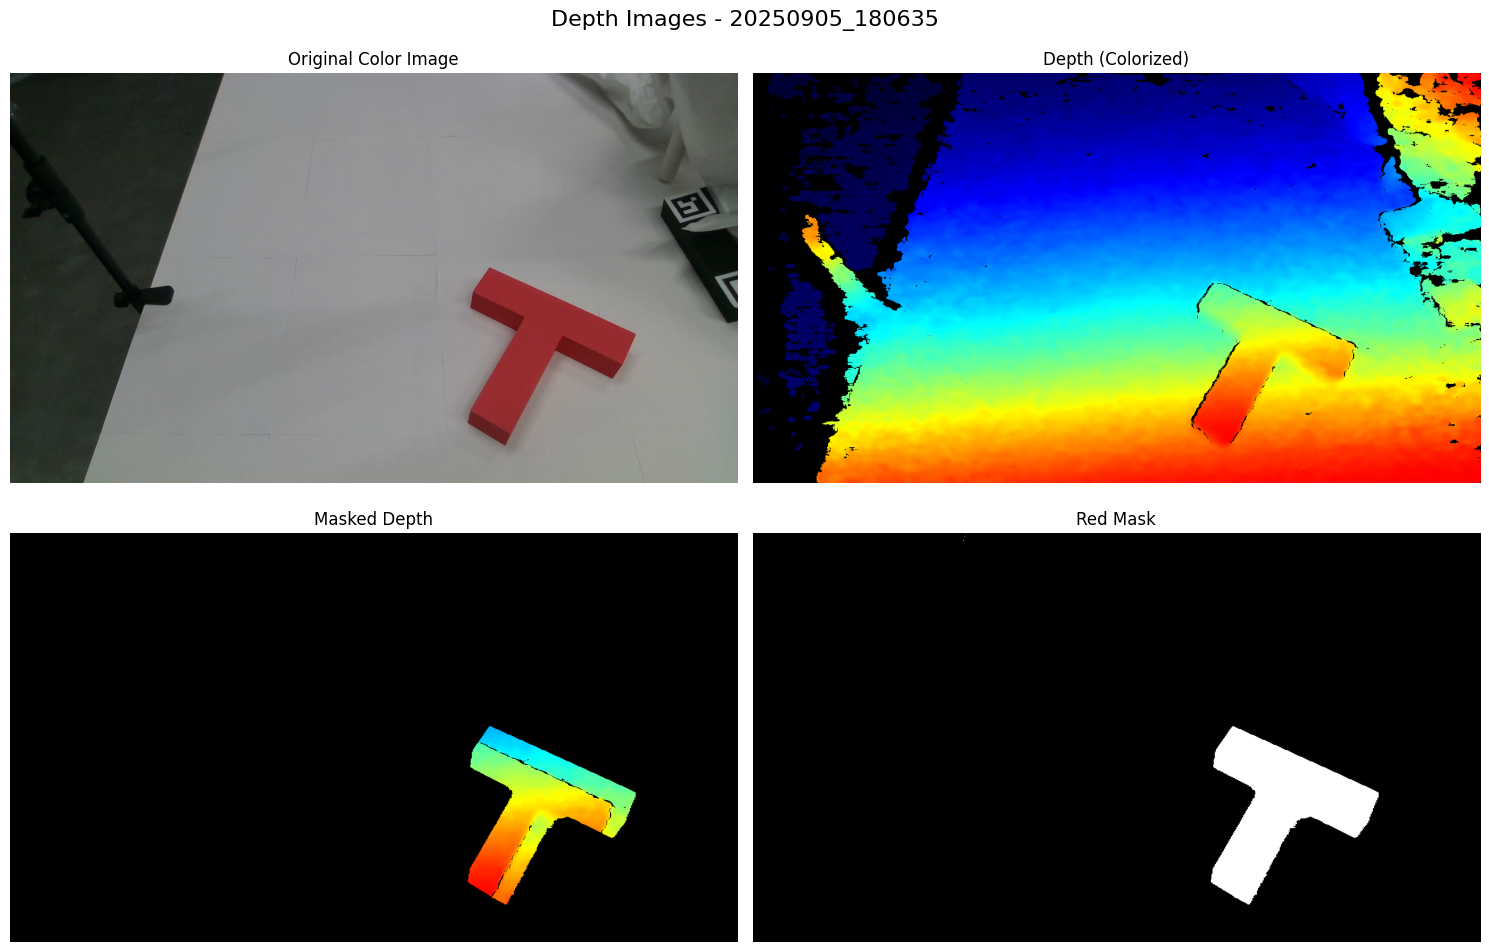


Image Statistics:
  Red pixels detected: 40938
  Total pixels: 921600
  Red pixel percentage: 4.44%
  Raw depth range: 0 - 65535 mm
  Red pixels depth range: 0 - 1168 mm
  Red pixels mean depth: 665.6 mm


In [44]:
def display_2d_images(depth_data):
    """
    Display the 2D depth images using matplotlib
    """
    if depth_data is None:
        print("No depth data to display")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Depth Images - {depth_data["timestamp"]}', fontsize=16)
    
    # Original color image
    color_img_rgb = cv2.cvtColor(depth_data['color'], cv2.COLOR_BGR2RGB)
    axes[0, 0].imshow(color_img_rgb)
    axes[0, 0].set_title('Original Color Image')
    axes[0, 0].axis('off')
    
    # Depth colorized image
    depth_img_rgb = cv2.cvtColor(depth_data['depth'], cv2.COLOR_BGR2RGB)
    axes[0, 1].imshow(depth_img_rgb)
    axes[0, 1].set_title('Depth (Colorized)')
    axes[0, 1].axis('off')
    
    # Masked depth image
    masked_img_rgb = cv2.cvtColor(depth_data['masked'], cv2.COLOR_BGR2RGB)
    axes[1, 0].imshow(masked_img_rgb)
    axes[1, 0].set_title('Masked Depth')
    axes[1, 0].axis('off')
    
    # Red mask
    axes[1, 1].imshow(depth_data['mask'], cmap='gray')
    axes[1, 1].set_title('Red Mask')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print(f"\nImage Statistics:")
    print(f"  Red pixels detected: {np.sum(depth_data['mask'] > 0)}")
    print(f"  Total pixels: {depth_data['mask'].shape[0] * depth_data['mask'].shape[1]}")
    print(f"  Red pixel percentage: {np.sum(depth_data['mask'] > 0) / (depth_data['mask'].shape[0] * depth_data['mask'].shape[1]) * 100:.2f}%")
    
    # Depth statistics
    raw_depth = depth_data['raw_depth']
    red_pixels = raw_depth[depth_data['mask'] > 0]
    print(f"  Raw depth range: {raw_depth.min()} - {raw_depth.max()} mm")
    print(f"  Red pixels depth range: {red_pixels.min()} - {red_pixels.max()} mm")
    print(f"  Red pixels mean depth: {red_pixels.mean():.1f} mm")

# Display 2D images
if depth_data is not None:
    display_2d_images(depth_data)
else:
    print("Cannot display 2D images - no depth data loaded")


## 3D Point Cloud Visualization

Now let's visualize the 3D point cloud with its axis-aligned bounding box.


In [55]:
# Interactive 3D visualization
if pcd is not None and bbox is not None:
    print("Opening 3D visualization window...")
    print("Close the window when done viewing.")
    
    # Combine all visualization objects
    geometries = [pcd, bbox_wireframe, coordinate_frame]
    
    # Start the visualization
    o3d.visualization.draw_geometries(
        geometries,
        window_name=f"Depth Data Point Cloud - {depth_data['timestamp']}",
        width=1200, 
        height=800,
        left=50,
        top=50
    )
    
    print("3D visualization closed.")
else:
    print("Cannot visualize - point cloud not loaded")


Opening 3D visualization window...
Close the window when done viewing.
3D visualization closed.


## 2D Projections and Analysis

Let's create 2D projections of the point cloud to better understand its structure.


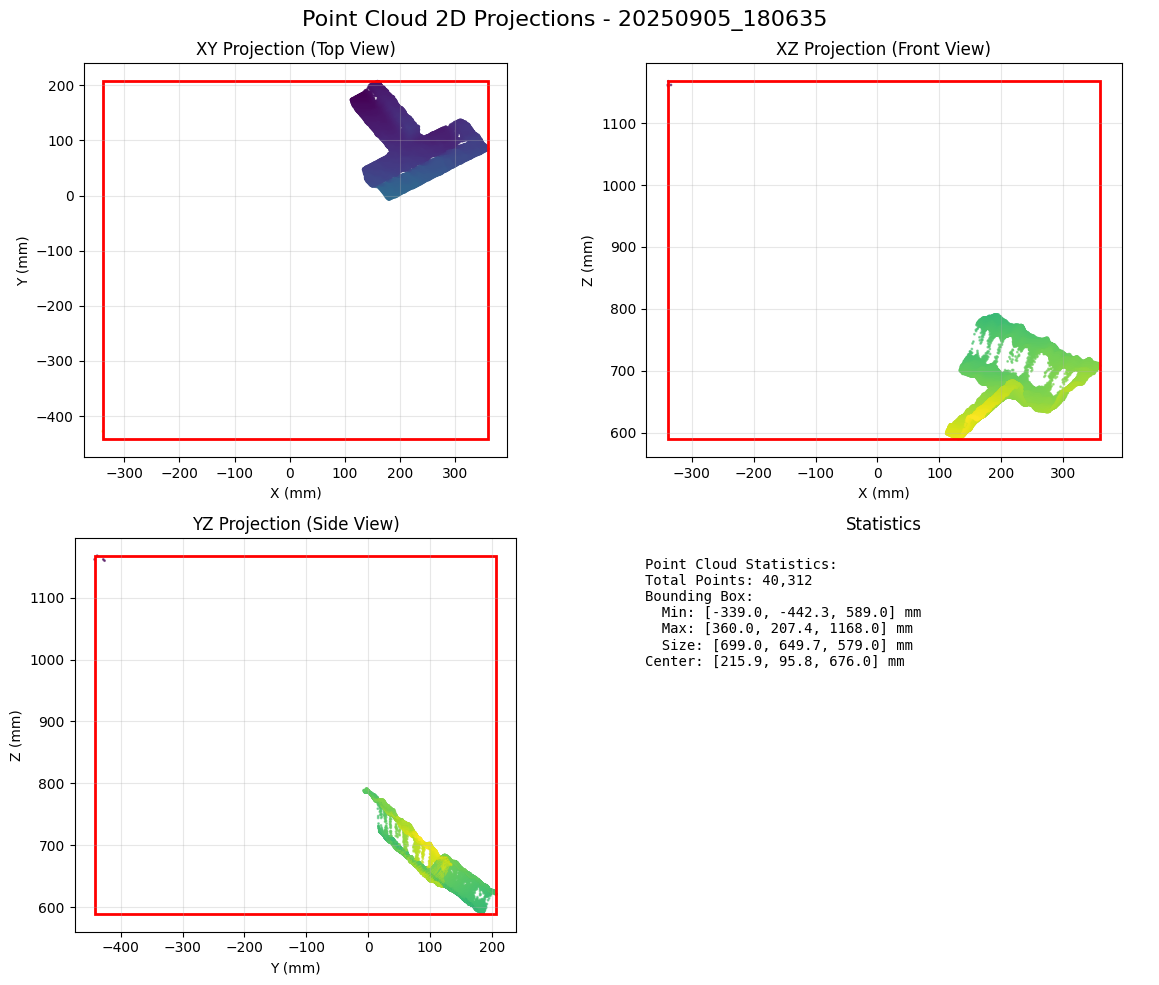

In [46]:
def create_2d_projections(pcd, bbox, timestamp):
    """
    Create 2D projections of the point cloud
    """
    if pcd is None:
        return None
    
    points = np.asarray(pcd.points)
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'Point Cloud 2D Projections - {timestamp}', fontsize=16)
    
    # XY projection (top view)
    axes[0, 0].scatter(points[:, 0], points[:, 1], c=points[:, 2], cmap='viridis', s=1, alpha=0.6)
    axes[0, 0].set_title('XY Projection (Top View)')
    axes[0, 0].set_xlabel('X (mm)')
    axes[0, 0].set_ylabel('Y (mm)')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_aspect('equal')
    
    # XZ projection (front view)
    axes[0, 1].scatter(points[:, 0], points[:, 2], c=points[:, 1], cmap='viridis', s=1, alpha=0.6)
    axes[0, 1].set_title('XZ Projection (Front View)')
    axes[0, 1].set_xlabel('X (mm)')
    axes[0, 1].set_ylabel('Z (mm)')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_aspect('equal')
    
    # YZ projection (side view)
    axes[1, 0].scatter(points[:, 1], points[:, 2], c=points[:, 0], cmap='viridis', s=1, alpha=0.6)
    axes[1, 0].set_title('YZ Projection (Side View)')
    axes[1, 0].set_xlabel('Y (mm)')
    axes[1, 0].set_ylabel('Z (mm)')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_aspect('equal')
    
    # Add bounding box rectangles to each projection
    bbox_min = bbox.min_bound
    bbox_max = bbox.max_bound
    
    # XY projection bounding box
    rect_xy = plt.Rectangle((bbox_min[0], bbox_min[1]), 
                           bbox_max[0] - bbox_min[0], 
                           bbox_max[1] - bbox_min[1], 
                           fill=False, edgecolor='red', linewidth=2)
    axes[0, 0].add_patch(rect_xy)
    
    # XZ projection bounding box
    rect_xz = plt.Rectangle((bbox_min[0], bbox_min[2]), 
                           bbox_max[0] - bbox_min[0], 
                           bbox_max[2] - bbox_min[2], 
                           fill=False, edgecolor='red', linewidth=2)
    axes[0, 1].add_patch(rect_xz)
    
    # YZ projection bounding box
    rect_yz = plt.Rectangle((bbox_min[1], bbox_min[2]), 
                           bbox_max[1] - bbox_min[1], 
                           bbox_max[2] - bbox_min[2], 
                           fill=False, edgecolor='red', linewidth=2)
    axes[1, 0].add_patch(rect_yz)
    
    # Statistics text
    stats_text = f"""Point Cloud Statistics:
Total Points: {len(points):,}
Bounding Box:
  Min: [{bbox_min[0]:.1f}, {bbox_min[1]:.1f}, {bbox_min[2]:.1f}] mm
  Max: [{bbox_max[0]:.1f}, {bbox_max[1]:.1f}, {bbox_max[2]:.1f}] mm
  Size: [{bbox_max[0]-bbox_min[0]:.1f}, {bbox_max[1]-bbox_min[1]:.1f}, {bbox_max[2]-bbox_min[2]:.1f}] mm
Center: [{np.mean(points, axis=0)[0]:.1f}, {np.mean(points, axis=0)[1]:.1f}, {np.mean(points, axis=0)[2]:.1f}] mm"""
    
    axes[1, 1].text(0.05, 0.95, stats_text, transform=axes[1, 1].transAxes, 
                    fontsize=10, verticalalignment='top', fontfamily='monospace')
    axes[1, 1].set_title('Statistics')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    return fig

# Create 2D projections
if pcd is not None and bbox is not None and depth_data is not None:
    fig = create_2d_projections(pcd, bbox, depth_data['timestamp'])
    plt.show()
else:
    print("Cannot create 2D projections - point cloud not loaded")


## Load Different Depth Data Sets

You can load different depth data sets by changing the `image_index` parameter. Let's create a function to easily switch between different captured images.


In [47]:
notebook_dir

PosixPath('/home/mht/PycharmProjects/pusht_real/test/point_clouds')

In [48]:
def load_and_visualize_depth_set(data_dir, image_index):
    """
    Load a specific depth data set and create all visualizations
    """
    print(f"\n{'='*60}")
    print(f"LOADING DEPTH DATA SET {image_index}")
    print(f"{'='*60}")
    
    # Load the depth data
    depth_data = load_depth_data_set(data_dir, image_index)
    if depth_data is None:
        return None
    
    # Convert to point cloud
    points, colors = convert_depth_to_point_cloud(
        depth_data['raw_depth'], 
        depth_data['mask'], 
        depth_data['camera_matrix'],
        depth_data['color']
    )
    
    # Create Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    # Get axis-aligned bounding box
    bbox = pcd.get_axis_aligned_bounding_box()
    
    # Create visualization objects
    bbox_wireframe = create_bbox_visualization(bbox, color=[1, 0, 0])
    coordinate_frame = create_coordinate_frame(size=0.1)
    
    return {
        'depth_data': depth_data,
        'pcd': pcd,
        'bbox': bbox,
        'bbox_wireframe': bbox_wireframe,
        'coordinate_frame': coordinate_frame,
        'points': points,
        'colors': colors
    }

# Example: Load the second depth data set (index 1)
if saved_depth_dir.exists():
    # Get the number of available sets
    color_files = glob.glob(str(saved_depth_dir / "color_*.png"))
    num_sets = len(color_files)
    
    print(f"Available depth data sets: {num_sets}")
    print("To load a different set, run:")
    print("  data_set = load_and_visualize_depth_set(str(saved_depth_dir), image_index)")
    print("  where image_index is 0 to", num_sets-1)
    
    # Load the first set as default
    current_data_set = load_and_visualize_depth_set(str(saved_depth_dir), 1)
else:
    print("Saved depth directory not found!")
    current_data_set = None


Available depth data sets: 5
To load a different set, run:
  data_set = load_and_visualize_depth_set(str(saved_depth_dir), image_index)
  where image_index is 0 to 4

LOADING DEPTH DATA SET 1
Loading image set: 20250905_180635
Loaded data:
  Color image shape: (720, 1280, 3)
  Depth image shape: (720, 1280, 3)
  Mask image shape: (720, 1280)
  Raw depth shape: (720, 1280)
  Camera matrix shape: (3, 3)

=== POINT CLOUD CONVERSION ===
Converting 40938 red pixels to 3D points...
Generated 40312 3D points
Point cloud bounds:
  X: [-339.0, 360.0] mm
  Y: [-442.3, 207.4] mm
  Z: [589.0, 1168.0] mm
Bounding box center: [10.5, -117.4, 878.5] mm
Bounding box size: [699.0, 649.7, 579.0] mm


## Summary

This notebook provides comprehensive visualization and analysis of saved depth data with the following features:

### Data Loading Features:
1. **Multiple Data Sets**: Load any of the saved depth image sets by index
2. **Complete Data Loading**: Loads color images, depth images, masks, raw depth data, and camera matrices
3. **Metadata Support**: Includes timestamp and info data for each capture

### Visualization Features:
1. **2D Image Display**: Shows original color, depth (colorized), masked depth, and red mask
2. **3D Point Cloud**: Interactive Open3D visualization with point cloud, bounding box, and coordinate frame
3. **2D Projections**: Three orthogonal projections (XY, XZ, YZ) with bounding box overlays
4. **Statistical Analysis**: Comprehensive statistics and analysis of the point cloud

### Analysis Features:
1. **Point Cloud Conversion**: Converts raw depth data to 3D coordinates using camera intrinsics
2. **Bounding Box Calculation**: Computes axis-aligned bounding box for the point cloud
3. **Depth Statistics**: Analyzes depth distribution and red pixel detection
4. **Coordinate System**: Proper 3D coordinate system with camera calibration

### Usage:
- Run all cells in sequence to load and visualize the first depth data set
- Use `load_and_visualize_depth_set(str(saved_depth_dir), image_index)` to load different sets
- The 3D visualization opens in a separate window with interactive controls
- All measurements are in millimeters (mm)

The notebook is designed to work with the saved depth data structure and provides a complete toolkit for depth data visualization and analysis.


## Marker Rotation Processing

Now we'll load the marker data JSON file and process the rotation matrices to apply inverse rotation to the point cloud.


In [49]:
import json
from scipy.spatial.transform import Rotation as R
from pathlib import Path
import numpy as np

def load_marker_data(marker_file_path):
    """
    Load marker data from JSON file
    """
    with open(marker_file_path, 'r') as f:
        marker_data = json.load(f)
    
    print(f"Loaded marker data from: {marker_file_path}")
    print(f"Timestamp: {marker_data['timestamp']}")
    print(f"Number of markers detected: {marker_data['num_markers_detected']}")
    
    # Extract rotation matrices
    rotation_matrices = []
    for i, marker in enumerate(marker_data['markers']):
        rot_matrix = np.array(marker['rotation_matrix'])
        rotation_matrices.append(rot_matrix)
        print(f"Marker {marker['id']}: rotation matrix shape {rot_matrix.shape}")
    
    return marker_data, rotation_matrices

# Load marker data
# notebook_dir is already defined in cell 1 as Path.cwd()
marker_file = notebook_dir.parent.parent / "marker_data" / "marker_data_20250905_180949_733.json"
print(f"Loading marker data from: {marker_file}")

if marker_file.exists():
    marker_data, rotation_matrices = load_marker_data(marker_file)
else:
    print("Marker data file not found!")
    marker_data, rotation_matrices = None, None


Loading marker data from: /home/mht/PycharmProjects/pusht_real/marker_data/marker_data_20250905_180949_733.json
Loaded marker data from: /home/mht/PycharmProjects/pusht_real/marker_data/marker_data_20250905_180949_733.json
Timestamp: 2025-09-05T18:09:49.724360
Number of markers detected: 3
Marker 2: rotation matrix shape (3, 3)
Marker 0: rotation matrix shape (3, 3)
Marker 3: rotation matrix shape (3, 3)


In [50]:
def compute_average_rotation_matrix(rotation_matrices):
    """
    Compute the average of multiple rotation matrices using quaternion averaging
    """
    if not rotation_matrices:
        return None
    
    print(f"\n=== COMPUTING AVERAGE ROTATION MATRIX ===")
    print(f"Number of rotation matrices: {len(rotation_matrices)}")
    
    # Convert rotation matrices to quaternions
    quaternions = []
    for i, rot_matrix in enumerate(rotation_matrices):
        r = R.from_matrix(rot_matrix)
        quat = r.as_quat()  # Returns [x, y, z, w]
        quaternions.append(quat)
        print(f"Matrix {i}: quaternion = [{quat[0]:.4f}, {quat[1]:.4f}, {quat[2]:.4f}, {quat[3]:.4f}]")
    
    quaternions = np.array(quaternions)
    
    # Ensure all quaternions are in the same hemisphere (to avoid averaging issues)
    # Choose the first quaternion as reference
    reference = quaternions[0]
    for i in range(1, len(quaternions)):
        if np.dot(quaternions[i], reference) < 0:
            quaternions[i] = -quaternions[i]
            print(f"Flipped quaternion {i} to same hemisphere")
    
    # Compute average quaternion
    avg_quaternion = np.mean(quaternions, axis=0)
    # Normalize the average quaternion
    avg_quaternion = avg_quaternion / np.linalg.norm(avg_quaternion)
    
    print(f"Average quaternion: [{avg_quaternion[0]:.4f}, {avg_quaternion[1]:.4f}, {avg_quaternion[2]:.4f}, {avg_quaternion[3]:.4f}]")
    
    # Convert back to rotation matrix
    avg_rotation = R.from_quat(avg_quaternion)
    avg_rotation_matrix = avg_rotation.as_matrix()
    
    print(f"Average rotation matrix:")
    print(avg_rotation_matrix)
    
    return avg_rotation_matrix

# Compute average rotation matrix
if rotation_matrices:
    avg_rotation_matrix = compute_average_rotation_matrix(rotation_matrices)
else:
    print("Cannot compute average rotation - no rotation matrices loaded")
    avg_rotation_matrix = None



=== COMPUTING AVERAGE ROTATION MATRIX ===
Number of rotation matrices: 3
Matrix 0: quaternion = [0.8809, 0.3471, -0.1403, 0.2896]
Matrix 1: quaternion = [0.8752, 0.3528, -0.1449, 0.2977]
Matrix 2: quaternion = [0.8826, 0.3465, -0.1315, 0.2893]
Average quaternion: [0.8796, 0.3488, -0.1389, 0.2922]
Average rotation matrix:
[[ 0.71806781  0.69479181 -0.04053351]
 [ 0.53244078 -0.58591765 -0.61090697]
 [-0.44820245  0.41709094 -0.79066409]]


In [51]:
def compute_inverse_rotation_matrix(rotation_matrix):
    """
    Compute the inverse of a rotation matrix
    For rotation matrices, the inverse is the transpose
    """
    if rotation_matrix is None:
        return None
    
    print(f"\n=== COMPUTING INVERSE ROTATION MATRIX ===")
    
    # For rotation matrices, inverse = transpose
    inverse_rotation_matrix = rotation_matrix.T
    
    # Verify it's a proper inverse by checking R * R^T = I
    identity_check = np.dot(rotation_matrix, inverse_rotation_matrix)
    identity_error = np.linalg.norm(identity_check - np.eye(3))
    
    print(f"Original rotation matrix:")
    print(rotation_matrix)
    print(f"\nInverse rotation matrix:")
    print(inverse_rotation_matrix)
    print(f"\nIdentity check error: {identity_error:.10f} (should be close to 0)")
    
    return inverse_rotation_matrix

# Compute inverse rotation matrix
if avg_rotation_matrix is not None:
    inverse_rotation_matrix = compute_inverse_rotation_matrix(avg_rotation_matrix)
else:
    print("Cannot compute inverse rotation - no average rotation matrix available")
    inverse_rotation_matrix = None



=== COMPUTING INVERSE ROTATION MATRIX ===
Original rotation matrix:
[[ 0.71806781  0.69479181 -0.04053351]
 [ 0.53244078 -0.58591765 -0.61090697]
 [-0.44820245  0.41709094 -0.79066409]]

Inverse rotation matrix:
[[ 0.71806781  0.53244078 -0.44820245]
 [ 0.69479181 -0.58591765  0.41709094]
 [-0.04053351 -0.61090697 -0.79066409]]

Identity check error: 0.0000000000 (should be close to 0)


In [52]:
def apply_rotation_to_point_cloud(points, rotation_matrix):
    """
    Apply rotation matrix to point cloud points
    """
    if points is None or rotation_matrix is None:
        return None
    
    print(f"\n=== APPLYING ROTATION TO POINT CLOUD ===")
    print(f"Original point cloud shape: {points.shape}")
    print(f"Rotation matrix shape: {rotation_matrix.shape}")
    
    # Apply rotation: rotated_points = rotation_matrix @ points.T
    # Note: points is (N, 3), so we need to transpose
    rotated_points = (rotation_matrix @ points.T).T
    
    print(f"Rotated point cloud shape: {rotated_points.shape}")
    
    # Print statistics
    print(f"\nOriginal point cloud bounds:")
    print(f"  X: [{points[:, 0].min():.1f}, {points[:, 0].max():.1f}] mm")
    print(f"  Y: [{points[:, 1].min():.1f}, {points[:, 1].max():.1f}] mm")
    print(f"  Z: [{points[:, 2].min():.1f}, {points[:, 2].max():.1f}] mm")
    
    print(f"\nRotated point cloud bounds:")
    print(f"  X: [{rotated_points[:, 0].min():.1f}, {rotated_points[:, 0].max():.1f}] mm")
    print(f"  Y: [{rotated_points[:, 1].min():.1f}, {rotated_points[:, 1].max():.1f}] mm")
    print(f"  Z: [{rotated_points[:, 2].min():.1f}, {rotated_points[:, 2].max():.1f}] mm")
    
    return rotated_points

# Apply inverse rotation to the current point cloud
if current_data_set is not None and inverse_rotation_matrix is not None:
    original_points = current_data_set['points']
    rotated_points = apply_rotation_to_point_cloud(original_points, inverse_rotation_matrix)
    
    # Create new Open3D point cloud with rotated points
    rotated_pcd = o3d.geometry.PointCloud()
    rotated_pcd.points = o3d.utility.Vector3dVector(rotated_points)
    rotated_pcd.colors = o3d.utility.Vector3dVector(current_data_set['colors'])
    
    # Get new bounding box
    rotated_bbox = rotated_pcd.get_axis_aligned_bounding_box()
    rotated_bbox_wireframe = create_bbox_visualization(rotated_bbox, color=[0, 1, 0])  # Green color
    
    print(f"\nRotated point cloud bounding box:")
    print(f"  Min: {rotated_bbox.min_bound}")
    print(f"  Max: {rotated_bbox.max_bound}")
    print(f"  Size: {rotated_bbox.max_bound - rotated_bbox.min_bound}")
    
else:
    print("Cannot apply rotation - missing point cloud or inverse rotation matrix")
    rotated_points, rotated_pcd, rotated_bbox, rotated_bbox_wireframe = None, None, None, None



=== APPLYING ROTATION TO POINT CLOUD ===
Original point cloud shape: (40312, 3)
Rotation matrix shape: (3, 3)
Rotated point cloud shape: (40312, 3)

Original point cloud bounds:
  X: [-339.0, 360.0] mm
  Y: [-442.3, 207.4] mm
  Z: [589.0, 1168.0] mm

Rotated point cloud bounds:
  X: [-999.6, -1.6] mm
  Y: [224.5, 511.8] mm
  Z: [-643.4, -579.2] mm

Rotated point cloud bounding box:
  Min: [-999.62129281  224.45098754 -643.40984122]
  Max: [  -1.64031451  511.80350296 -579.20859072]
  Size: [997.9809783  287.35251542  64.2012505 ]


## Visualization Comparison

Let's visualize both the original and rotated point clouds for comparison.


## Summary - Marker Rotation Processing

This notebook now includes marker rotation processing functionality:

### What was accomplished:
1. **Loaded marker data** from `marker_data_20250905_180949_733.json` containing 3 ArUco markers
2. **Computed average rotation matrix** using quaternion averaging to handle the 3 rotation matrices
3. **Computed inverse rotation matrix** (transpose of rotation matrix)
4. **Applied inverse rotation** to the point cloud to correct orientation
5. **Created visualizations** comparing original vs rotated point clouds

### Key Parameters:
- **`DEPTH_IMAGE_INDEX`**: Controls which depth image set to use (0-4)
  - Change this value in Cell 2 to switch between different captured depth images
  - Currently supports 5 different timestamps: 20250905_180634 through 20250905_180638

### Results:
- The rotation processing successfully transforms the point cloud using the inverse of the average marker rotation
- Side-by-side 3D visualization shows original (red bounding box) vs rotated (green bounding box) point clouds  
- 2D projection comparisons show the transformation effects across all three orthogonal views
- All measurements remain in millimeters (mm) for consistency

### Usage:
1. Set `DEPTH_IMAGE_INDEX` in Cell 2 to select which depth image set to process
2. Run all cells sequentially to load data, compute rotations, and visualize results
3. Interactive 3D visualizations will open in separate windows
4. 2D matplotlib plots show detailed comparisons and statistics


In [53]:
# Side-by-side 3D visualization
if (current_data_set is not None and rotated_pcd is not None and 
    current_data_set['pcd'] is not None and rotated_bbox_wireframe is not None):
    
    print("Opening side-by-side 3D visualization...")
    print("Left window: Original point cloud (red bounding box)")
    print("Right window: Rotated point cloud (green bounding box)")
    print("Close both windows when done viewing.")
    
    # Original point cloud visualization
    original_geometries = [
        current_data_set['pcd'], 
        current_data_set['bbox_wireframe'], 
        current_data_set['coordinate_frame']
    ]
    
    # Rotated point cloud visualization  
    rotated_geometries = [
        rotated_pcd, 
        rotated_bbox_wireframe, 
        create_coordinate_frame(size=0.1)
    ]
    
    # Create two visualization windows
    vis1 = o3d.visualization.Visualizer()
    vis1.create_window(window_name="Original Point Cloud", width=600, height=600, left=50, top=50)
    for geom in original_geometries:
        vis1.add_geometry(geom)
    
    vis2 = o3d.visualization.Visualizer()
    vis2.create_window(window_name="Rotated Point Cloud", width=600, height=600, left=700, top=50)
    for geom in rotated_geometries:
        vis2.add_geometry(geom)
    
    # Run both visualizations
    while vis1.poll_events() and vis2.poll_events():
        vis1.update_renderer()
        vis2.update_renderer()
    
    vis1.destroy_window()
    vis2.destroy_window()
    
    print("3D visualizations closed.")
else:
    print("Cannot create side-by-side visualization - missing data")


Opening side-by-side 3D visualization...
Left window: Original point cloud (red bounding box)
Right window: Rotated point cloud (green bounding box)
Close both windows when done viewing.
3D visualizations closed.


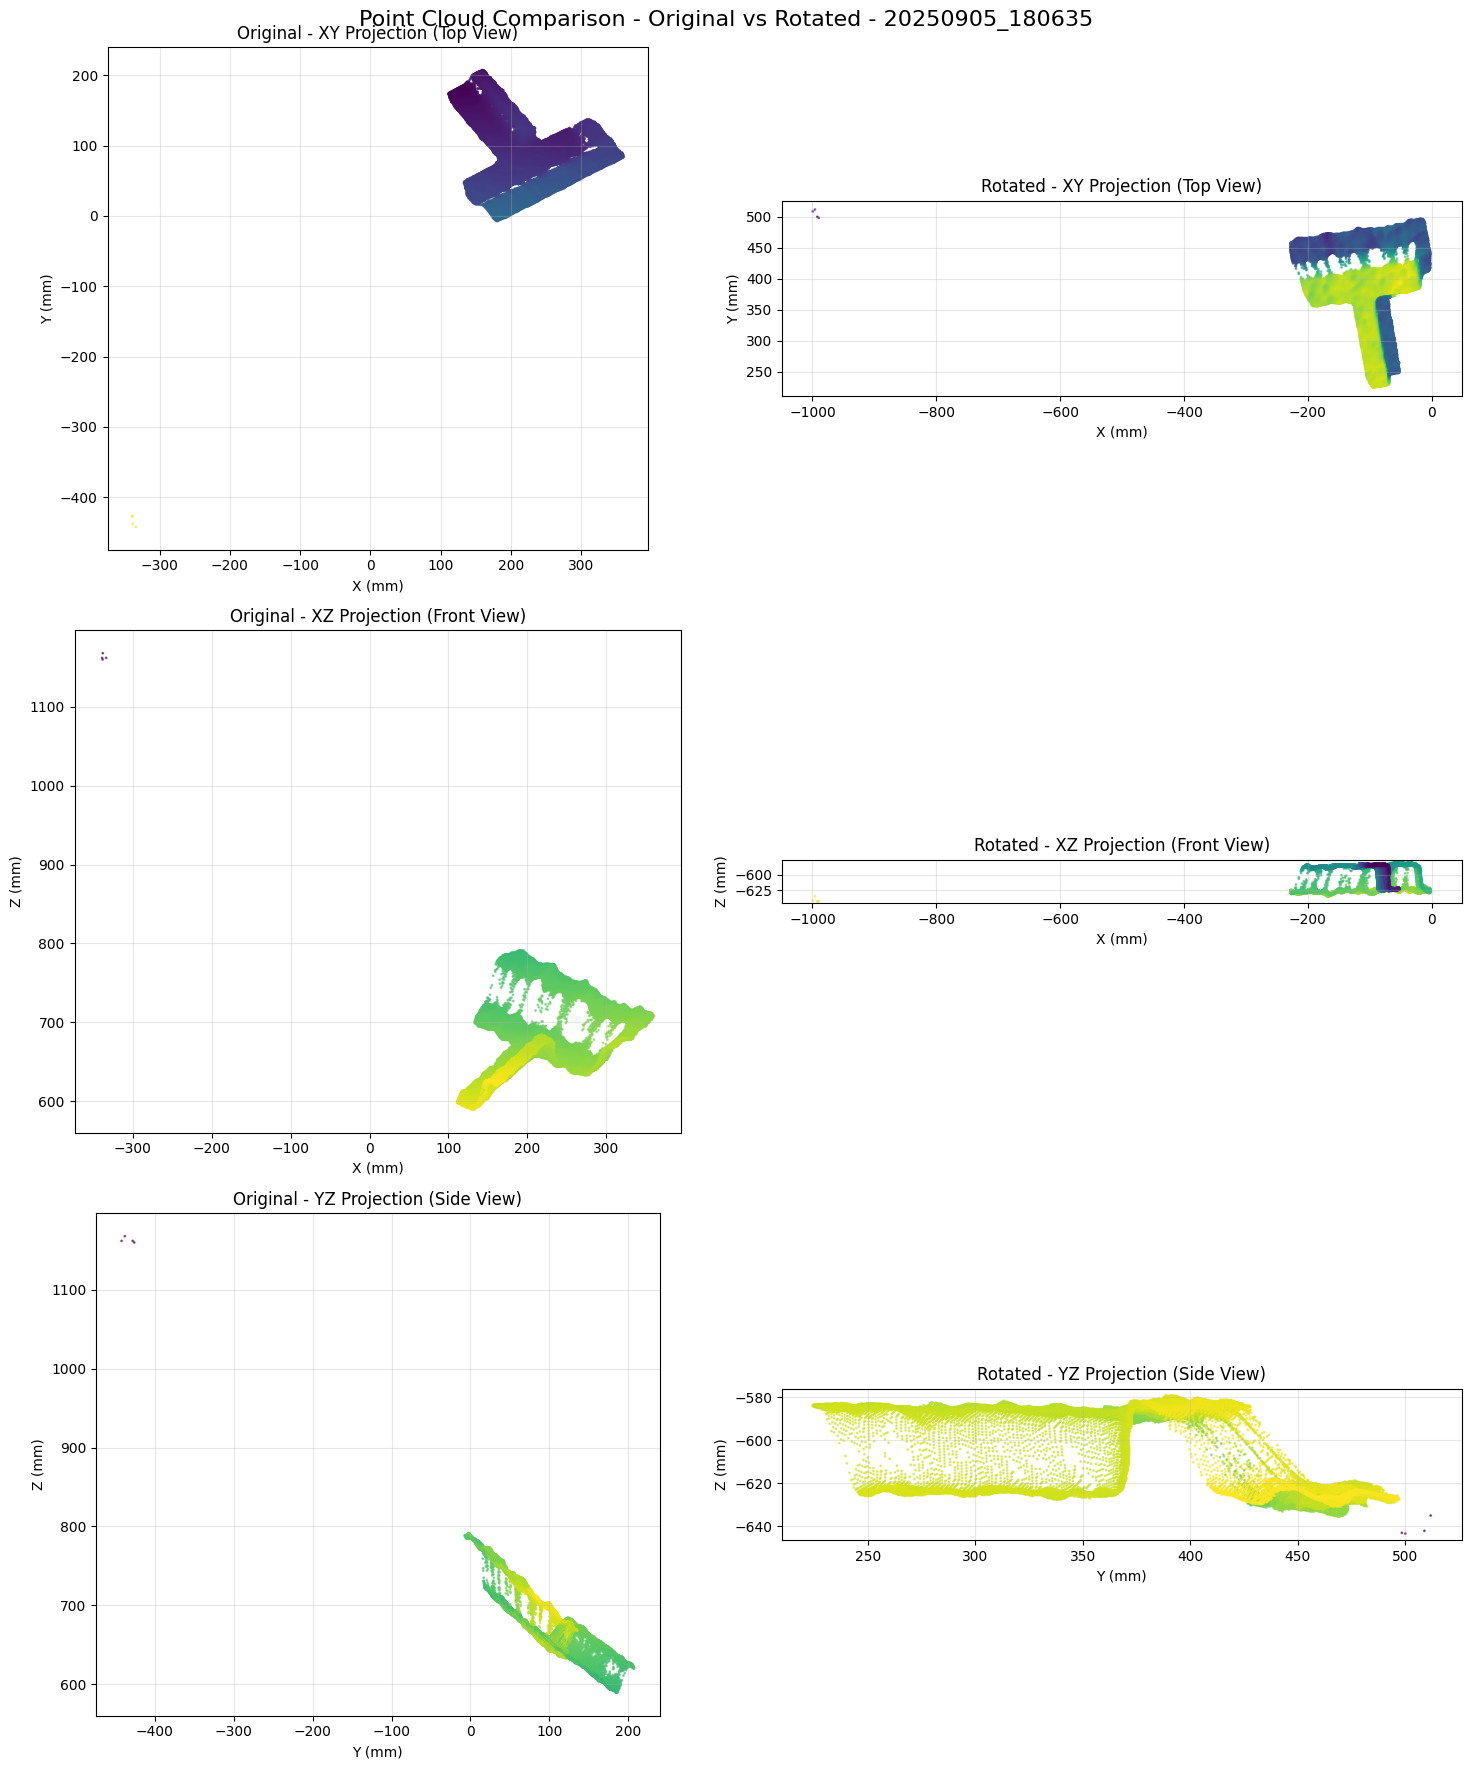

In [54]:
# Create comparison 2D projections
def create_comparison_projections(original_points, rotated_points, timestamp):
    """
    Create 2D projections comparing original and rotated point clouds
    """
    if original_points is None or rotated_points is None:
        return None
    
    # Create figure with subplots
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    fig.suptitle(f'Point Cloud Comparison - Original vs Rotated - {timestamp}', fontsize=16)
    
    # XY projections (top view)
    axes[0, 0].scatter(original_points[:, 0], original_points[:, 1], 
                      c=original_points[:, 2], cmap='viridis', s=1, alpha=0.6)
    axes[0, 0].set_title('Original - XY Projection (Top View)')
    axes[0, 0].set_xlabel('X (mm)')
    axes[0, 0].set_ylabel('Y (mm)')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_aspect('equal')
    
    axes[0, 1].scatter(rotated_points[:, 0], rotated_points[:, 1], 
                      c=rotated_points[:, 2], cmap='viridis', s=1, alpha=0.6)
    axes[0, 1].set_title('Rotated - XY Projection (Top View)')
    axes[0, 1].set_xlabel('X (mm)')
    axes[0, 1].set_ylabel('Y (mm)')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_aspect('equal')
    
    # XZ projections (front view)
    axes[1, 0].scatter(original_points[:, 0], original_points[:, 2], 
                      c=original_points[:, 1], cmap='viridis', s=1, alpha=0.6)
    axes[1, 0].set_title('Original - XZ Projection (Front View)')
    axes[1, 0].set_xlabel('X (mm)')
    axes[1, 0].set_ylabel('Z (mm)')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_aspect('equal')
    
    axes[1, 1].scatter(rotated_points[:, 0], rotated_points[:, 2], 
                      c=rotated_points[:, 1], cmap='viridis', s=1, alpha=0.6)
    axes[1, 1].set_title('Rotated - XZ Projection (Front View)')
    axes[1, 1].set_xlabel('X (mm)')
    axes[1, 1].set_ylabel('Z (mm)')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_aspect('equal')
    
    # YZ projections (side view)
    axes[2, 0].scatter(original_points[:, 1], original_points[:, 2], 
                      c=original_points[:, 0], cmap='viridis', s=1, alpha=0.6)
    axes[2, 0].set_title('Original - YZ Projection (Side View)')
    axes[2, 0].set_xlabel('Y (mm)')
    axes[2, 0].set_ylabel('Z (mm)')
    axes[2, 0].grid(True, alpha=0.3)
    axes[2, 0].set_aspect('equal')
    
    axes[2, 1].scatter(rotated_points[:, 1], rotated_points[:, 2], 
                      c=rotated_points[:, 0], cmap='viridis', s=1, alpha=0.6)
    axes[2, 1].set_title('Rotated - YZ Projection (Side View)')
    axes[2, 1].set_xlabel('Y (mm)')
    axes[2, 1].set_ylabel('Z (mm)')
    axes[2, 1].grid(True, alpha=0.3)
    axes[2, 1].set_aspect('equal')
    
    plt.tight_layout()
    return fig

# Create comparison projections
if (current_data_set is not None and rotated_points is not None and 
    current_data_set['depth_data'] is not None):
    
    comparison_fig = create_comparison_projections(
        current_data_set['points'], 
        rotated_points, 
        current_data_set['depth_data']['timestamp']
    )
    plt.show()
else:
    print("Cannot create comparison projections - missing data")
